In [1]:
import numpy as np
import inspect
import os
import sklearn
import math
from sklearn.manifold import TSNE
from sklearn import manifold, mixture, cluster
from sqlalchemy import func, select as sqlselect, distinct
from matplotlib import pylab
import matplotlib.colors as colors
import matplotlib.cm as cmx
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir)

from api import app, db
from server.models import Genre, Artist, Song, ArtistGenres, SongTracks, SongGroup, Group
from server import song_helper

%matplotlib inline
genres, _ = song_helper.db_load_genres()
genres[0] = '-unk-'

In [15]:
feature_names = ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'loudness', 
                'valence', 'danceability', 'key', 'mode', 'time_signature']


def select_top_songs():
    return db.session.query(Song).filter(Song.IsToplistSong == 1)
def count_top_songs():
    return db.session.query(func.count(Song.SongId)).filter(Song.IsToplistSong == 1)



def select_song_group(group_id):
    def select_song_group_i():
        return db.session.query(Song).join(SongGroup).filter(SongGroup.GroupId == group_id)
    return select_song_group_i


def count_song_group(group_id):
    def count_song_group_i():
        return db.session.query(func.count(Song.SongId)).join(SongGroup).filter(SongGroup.GroupId == group_id)
    return count_song_group_i


def select_song_group_type(group_type):
    def select_song_group_type_i():
        return db.session.query(Song).join(SongGroup).join(Group).filter(Group.Type == group_type).distinct()
    return select_song_group_type_i


def count_song_group_type(group_type):
    def count_song_group_type_i():
        return db.session.query(func.count(distinct(Song.SongId))).join(SongGroup).join(Group).filter(Group.Type == group_type)
    return count_song_group_type_i


def load_songs(select, count):
    songs_count = count().scalar()
    print('will load %i songs' % songs_count)    
    song_names = {}
    song_features = np.ndarray((songs_count, 16), dtype=np.float32)    
    row = 0
    for song in select():
        song_features[row, 0] = isnull(song.AS_energy)
        song_features[row, 1] = isnull(song.AS_liveness)
        song_features[row, 2] = isnull(song.AS_tempo)
        song_features[row, 3] = isnull(song.AS_speechiness)
        song_features[row, 4] = isnull(song.AS_acousticness)
        song_features[row, 5] = isnull(song.AS_instrumentalness)
        song_features[row, 6] = isnull(song.AS_loudness)
        song_features[row, 7] = isnull(song.AS_valence)
        song_features[row, 8] = isnull(song.AS_danceability)
        song_features[row, 9] = isnull(song.AS_key)
        song_features[row, 10] = isnull(song.AS_mode)
        song_features[row, 11] = isnull(song.AS_time_signature)
        song_features[row, 12] = song.DurationMs
        song_features[row, 13] = song.SongId
        song_features[row, 14] = 0 if song.Genre is None else song.GenreId
        song_features[row, 15] = song.ArtistId
        
        song_names[song.SongId] = song.Name        
        row += 1
    if row != songs_count:
        raise Exception('got %i songs, expected %i' % (row, songs_count))
        
    return song_features, song_names


def load_artist_genres():
    s = sqlselect([ArtistGenres.GenreId, ArtistGenres.ArtistId]).order_by(ArtistGenres.ArtistId)\
                                                                .order_by(ArtistGenres.Ord)
    rows = db.session.execute(s).fetchall()
    a_genres = {}
    for row in rows:
        if row[1] not in a_genres:
            a_genres[row[1]] = [row[0]]
        else:
            a_genres[row[1]].append(row[0])
    return a_genres
        

def isnull(v, r=0):
    return v if v is not None else 0
    

def plot(projection, labels, annotate=True, color=None, plot_size=15):
    #assert projection.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(plot_size, plot_size))  # in inches
    for l_id in labels:
        x, y = projection[l_id-1,:]
        if color is not None:
            pylab.scatter(x,y, c=color[i], s=500, cmap='gray')
        else:
            pylab.scatter(x, y)
        if annotate:
            pylab.annotate(labels[l_id], xy=(x, y), xytext=(5, 2), textcoords='offset points',
                           ha='right', va='bottom')
    pylab.show()
    
    
def plot2(projection, labels, annotate=True, color=None):
    assert projection.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    pylab.scatter(projection[:,0],projection[:,1], c=color, s=30)
    #pylab.colorbar()
    pylab.show()
    
def plot3(projection, labels, color):    
    pylab.figure(figsize=(15,10))  # in inches
    max_color = np.max(color)
    jet = cm = pylab.get_cmap('jet')
    cNorm  = colors.Normalize(vmin=0, vmax=max_color)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    
    # display color by color
    for c in list(np.unique(color)):
        col = scalarMap.to_rgba(c)
        pylab.scatter(projection[color == c,0], projection[color==c,1],c=col, s=30,
                      label=labels[c])#'color: (%4.2f,%4.2f,%4.2f)'%(col[0],col[1],col[2]))
        
    
    pylab.legend()
    pylab.show()
    

def tsne_projection(song_features):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    return tsne.fit_transform(song_features)
    

def prepare_songs(song_features, scaler=None):
    permutation = np.random.permutation(song_features.shape[0])
    song_features = song_features[permutation,:]
    song_genres = song_features[:,14]
    # normalize features
    normalized_features = song_features[:,0:9]
    features_mean = np.mean(normalized_features, axis=0)
    features_std = np.std(normalized_features, axis=0)
    scaler = scaler or sklearn.preprocessing.StandardScaler(copy=False).fit(normalized_features)
    scaler.transform(normalized_features)    
    return song_features, song_genres, features_mean, features_std, scaler

In [3]:
song_features, song_names = load_songs(select_top_songs, count_top_songs)

will load 835368 songs


In [4]:
song_features, song_genres, features_mean, features_std, features_scaler = prepare_songs(song_features)

In [64]:
featured_features = [0,1,2,3,4,5,7,8]
feature_minimum = np.min(song_features, axis=0)
feature_maximum = np.max(song_features, axis=0)


def print_features(f_vec):
    for i in range(len(f_vec)):
        print('%s: %i%% (%f)'%(feature_names[i], (f_vec[i] - feature_minimum[i])*100/(feature_maximum[i] - 
                                                                                    feature_minimum[i]), f_vec[i]))
        
def get_core_genres(gr_song_genres):
    # print(gr_song_genres[gr_song_genres < 0])
    gr_g_array = np.array(gr_song_genres, dtype=np.int64)
    gr_g_bins = np.bincount(gr_g_array)
    gr_g_bin_sort = np.argsort(gr_g_bins)[::-1]
    # get maximum 20 genres
    min_g_count = 1
    if len(gr_g_bin_sort) > 20:
        min_g_count = max(gr_g_bins[gr_g_bin_sort[20]], 1)
    for sort_id in gr_g_bin_sort:
        c = gr_g_bins[sort_id]
        if c >= min_g_count:
            print ('Genre %s count %i' % (genres[sort_id], c))

    gr_top_g = gr_g_bin_sort[gr_g_bins[gr_g_bin_sort] >= min_g_count]
    # print(gr_top_g)
    # print(len(gr_song_genres))
    # print(len(gr_song_genres[gr_song_genres>=0]))
    # print(gr_song_genres[gr_song_genres>=0])
    # print(str(gr_song_genres))
    gr_top_g_indexer = np.ndarray(len(gr_song_genres), dtype=np.bool)    
    for i, g in enumerate(gr_song_genres):
        gr_top_g_indexer[i] = g in gr_top_g and g != 0
        
    return gr_top_g_indexer
        
        
def outliers_info(features, core_features, gr_song_features, gr_song_names, genres):
    # novelty detection
    clf = sklearn.svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
    clf.fit(core_features) # gr_song_features[gr_top_g_indexer][:,featured_features]
    y_pred_train = clf.predict(features)
    print('%% of outliers in dataset: %f%%' % (y_pred_train[y_pred_train == -1].size * 100.0 / features.shape[0]))
    y_decision_train = clf.decision_function(features)[:,0]
    y_decision_train_sort = np.argsort(y_decision_train)
    for sort_id in y_decision_train_sort[:20]:
        if y_pred_train[sort_id] == -1:
            song = gr_song_features[sort_id]
            print('song %s-%s(%i) is outlier with dist %f' % (gr_song_names[song[13]], genres[song[14]],
                                                              song[13], y_decision_train[sort_id]))
    print('most crazy outlier')
    print(print_features(gr_song_features[y_decision_train_sort[0],0:9]))

    print('')
    y_decision_train_sort = y_decision_train_sort[::-1]
    for sort_id in y_decision_train_sort[:20]:
        if y_pred_train[sort_id] == 1:
            song = gr_song_features[sort_id]
            print('song %s-%s(%i) is ingroup with dist %f' % (gr_song_names[song[13]], genres[song[14]],
                                                              song[13], y_decision_train[sort_id]))
    print('most ingrouped')
    print(print_features(gr_song_features[y_decision_train_sort[0],0:9]))
    # y_pred_top = clf.predict(gr_song_features[gr_top_g_indexer][:,0:9])
    # print(y_pred_top[y_pred_top == -1].size * 100.0 / gr_song_features[gr_top_g_indexer].shape[0])


def plot_clusters(features, y_pred, n_clusters_):
    y_pred = y_pred + 1
    print('count elements in clusters %s' % str(np.bincount(y_pred)))
    components = {0: 'noise samples'}
    for c in range(1, n_clusters_+1):
        components[c] = 'component %i' % c
    projection = tsne_projection(features) #
    plot3(projection, components, color=y_pred)
    
    
def fit_dpgmm(features, n_components=3):        
    # choose best model: commented out as GMM is clearly inferior
    # lowest_bic = np.infty
    # bic = []
    # n_components_range = range(1, 10)
    #cv_types = ['spherical', 'tied', 'diag', 'full']
    #for cv_type in cv_types:
    #    for n_components in n_components_range:
    #        # Fit a mixture of Gaussians with EM
    #        gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type, n_iter=1000)
    #        gmm.fit(features)
    #        bic.append(gmm.bic(features))
    #        if bic[-1] < lowest_bic:
    #            lowest_bic = bic[-1]
    #            best_gmm = gmm
    # y_pred = best_gmm.predict(features)
    
    # Fit a Dirichlet process mixture 
    dpgmm = sklearn.mixture.DPGMM(n_components=n_components, covariance_type='tied', n_iter=1000, verbose=0) #, alpha=5
    dpgmm.fit(features)
    y_pred = dpgmm.predict(features)
    plot_clusters(features, y_pred, 15)
    return y_pred
    
    
def fit_DBSCAN(features):
    cls = sklearn.cluster.DBSCAN(eps=0.5, min_samples=20)
    cls.fit(features)
    y_pred = cls.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(y_pred)) - (1 if -1 in y_pred else 0)
    plot_clusters(features, y_pred, n_clusters_)
    return y_pred
    

def fit_affinity_prop(features):
    cls = sklearn.cluster.AffinityPropagation(preference=-60)
    cls.fit(features)
    y_pred = cls.labels_
    # Number of clusters in labels, ignoring noise if present.
    cluster_centers_indices = cls.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    plot_clusters(features, y_pred, n_clusters_)
    return y_pred
    

def kmeans_gap_statistics(df, max_k):
    # https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/
    # https://github.com/Zelazny7/gap-statistic/blob/master/gap.py
    def get_rand_data(col):
        rng = col.max() - col.min()
        return np.random.random_sample(len(col))*rng + col.min()
    
    def iter_kmeans(refs, n_clusters):
        vals = np.zeros(len(refs))
        k = sklearn.cluster.KMeans(n_clusters=n_clusters)
        for i in range(len(refs)):            
            k.fit(refs[i])
            # print('Ref k: %s' % k.get_params()['n_clusters'])
            vals[i] = k.inertia_
        return vals
    
    gaps = np.zeros(max_k)
    sks = np.zeros(max_k)
    B = 10 # number of test data sets
    refs = [np.apply_along_axis(get_rand_data, 0, df) for b in range(B)]
    print(len(refs))
    for k in range(max_k):
        km_act = sklearn.cluster.KMeans(n_clusters=k+1)
        km_act.fit(df)
        logWk = np.log(km_act.inertia_)        
        logWkbs = np.log(iter_kmeans(refs, n_clusters=k+1))
        logWkb = sum(logWkbs)/B
        gaps[k] = logWkb - logWk        
        sks[k] = np.sqrt(sum((logWkbs-logWkb)**2)/B)*np.sqrt(1+1/B)
        print('logWkb: %f   logWk: %f  gap: %f sks: %f delta: %f' %
              ( logWkb, logWk, gaps[k], sks[k], gaps[k]-sks[k]))            
    
    for n_clusters_ in range(max_k-1):
        if gaps[n_clusters_] > gaps[n_clusters_+1] - sks[n_clusters_+1]:
            break
    return n_clusters_+1


def kmeans_f_of_K(features, max_k):
    def f_of_K(X, ck, Skm1=0):    
        # http://www.ee.columbia.edu/~dpwe/papers/PhamDN05-kmeans.pdf
        # https://datasciencelab.wordpress.com/2014/01/21/selection-of-k-in-k-means-clustering-reloaded/
        # http://www.stat.cmu.edu/~ryantibs/datamining/lectures/06-clus3.pdf
        Nd = X.shape[1]
        # print(Nd)
        a = lambda k, Nd: 1 - 3/(4*Nd) if k == 2 else a(k-1, Nd) + (1-a(k-1, Nd))/6
        km = sklearn.cluster.KMeans(n_clusters=ck)
        km.fit(X)
        #dists = km.transform(X)
        #Sk = 0
        #for k in range(ck):
        #    Sk += sum(dists[km.labels_==k, k])
        clusters = km.labels_
        mu = km.cluster_centers_
        # print(mu)
        Sk = sum([np.linalg.norm(mu[i]-c)**2 for i in range(ck) for c in X[clusters==i]])
        if ck == 1:
            fs = 1
        elif Skm1 == 0:
            fs = 1
        else:
            fs = Sk/(a(ck,Nd)*Skm1)
        return fs, Sk 

    fs = np.zeros(max_k)
    fs[0], Sk = f_of_K(features, 1)
    for k in range(2, max_k+1):
        fs[k-1], Sk = f_of_K(features, k, Skm1=Sk)
        print('clusters %i f_of_K %f' % (k, fs[k-1]))
    # print(fs)
    return np.argmin(fs) + 1


def kmeans_silhouette(features, max_k):
    best_n_clusters = None
    best_score = -1 # worst possible

    for n_clusters_ in range(2, max_k+1):
        cls = sklearn.cluster.KMeans(n_clusters=n_clusters_)
        cls.fit(features)
        y_pred = cls.labels_
        score = sklearn.metrics.silhouette_score(features, y_pred)
        print('%i clusters score %f' % (n_clusters_, score))
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters_    

    return best_n_clusters


def fit_kmeans(features, n_clusters_):
    cls = sklearn.cluster.KMeans(n_clusters=n_clusters_)
    cls.fit(features)
    y_pred = cls.labels_
    plot_clusters(features, y_pred, n_clusters_)
    
    return y_pred
    
    
def describe_songs(gr_song_features, gr_song_names, gr_song_genres):    
    features = gr_song_features[:,featured_features]
    printable_features = gr_song_features[:,:9]
    
    gr_top_g_indexer = get_core_genres(gr_genres)
    core_features = genre_core_features(features, gr_genres)
    projection = tsne_projection(core_features)
    plot3(projection, genres, color=gr_song_genres[gr_top_g_indexer])
    print('')
    print('mean features for all songs in group')
    gr_song_mean = np.mean(printable_features, axis=0)
    # print(gr_song_mean)
    print_features(gr_song_mean)
    print('')
    print('mean features for all songs in top genres')
    gr_song_mean = np.mean(printable_features[gr_top_g_indexer], axis=0)
    print_features(gr_song_mean)
    print('')
    print('outliers information')
    outliers_info(features, core_features, gr_song_features, gr_song_names, genres)
    print('')
    print('clustering with DPGMM')
    fit_dpgmm(features)
    print('')
    print('clustering with DBSCAN')
    fit_DBSCAN(features)
    print('')
    print('clustering with affinity propagation')
    fit_affinity_prop(features)
    max_k = 10
    print('')
    print('detection no cluster with kmeans_gap_statistics')
    nc = kmeans_gap_statistics(features, max_k)
    print('got %i clusters' % nc)
    print('')
    print('detection no cluster with kmeans_silhouette')
    nc = kmeans_silhouette(features, max_k)
    print('got %i clusters' % nc)
    print('')
    print('detection no cluster with kmeans_f_of_K')
    nc = kmeans_f_of_K(features, max_k)
    print('got %i clusters -> used for plotting' % nc)
    fit_kmeans(features, nc)
    print('')
    print('')
    
    
def describe_song_group(group_name, group_id):
    print('GROUP %s(%i) INFO' % (group_name, group_id))
    print('--------------------------------------')
    gr_song_features, gr_song_names = load_songs(select_song_group(group_id), count_song_group(group_id))
    gr_song_features, gr_song_genres, _, _, _ = prepare_songs(gr_song_features, features_scaler)
    describe_songs(gr_song_features, gr_song_names, gr_song_genres)
    
def describe_song_group_type(name, group_type):
    print('GROUP TYPE %s(%i) INFO' % (name, group_type))
    print('--------------------------------------')
    gr_song_features, gr_song_names = load_songs(select_song_group_type(group_type), count_song_group_type(group_type))
    gr_song_features, gr_song_genres, _, _, _ = prepare_songs(gr_song_features, features_scaler)
    #for i in range(gr_song_features.shape[1]):
    #    for j in range(gr_song_features.shape[0]):
    #        if np.isnan(gr_song_features[j,i]):
    #            print('nan detected x %i y %i' % (j,i))
            
    #for i in range(gr_song_features.shape[1]):
    #    print('%i: %s' % (i, str(gr_song_features[np.isnan(gr_song_features[:,i]),i])))
    describe_songs(gr_song_features, gr_song_names, gr_song_genres)

GROUP forest(43) INFO
--------------------------------------
will load 15 songs
Genre environmental count 7
Genre -unk- count 6
Genre sleep count 2


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


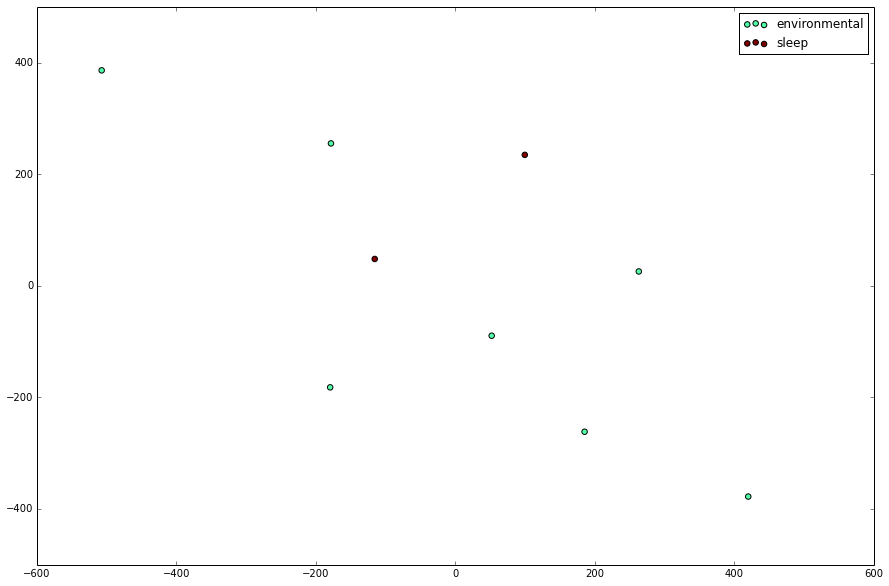


mean features for all songs in group
energy: 28% (-1.178717)
liveness: 31% (0.472852)
tempo: 42% (-0.474244)
speechiness: 35% (1.893433)
acousticness: 44% (0.262872)
instrumentalness: 88% (1.814651)
loudness: 38% (-4.468088)
valence: 6% (-1.535657)
danceability: 30% (-1.281748)

mean features for all songs in top genres
energy: 35% (-0.924032)
liveness: 33% (0.616823)
tempo: 41% (-0.601221)
speechiness: 15% (0.401723)
acousticness: 38% (0.099706)
instrumentalness: 88% (1.823837)
loudness: 38% (-4.468088)
valence: 3% (-1.648523)
danceability: 23% (-1.623069)

outliers information
% of outliers in dataset: 53.333333%
song Morning Songbirds--unk-(835275) is outlier with dist -0.218388
song Birds of the Forest--unk-(835276) is outlier with dist -0.199094
song A Little Bird Told Me (Bird Calls for Birds)--unk-(835281) is outlier with dist -0.068384
song Frogs Sound--unk-(835272) is outlier with dist -0.047565
song Forest Sounds-environmental(835273) is outlier with dist -0.000155
song Chor

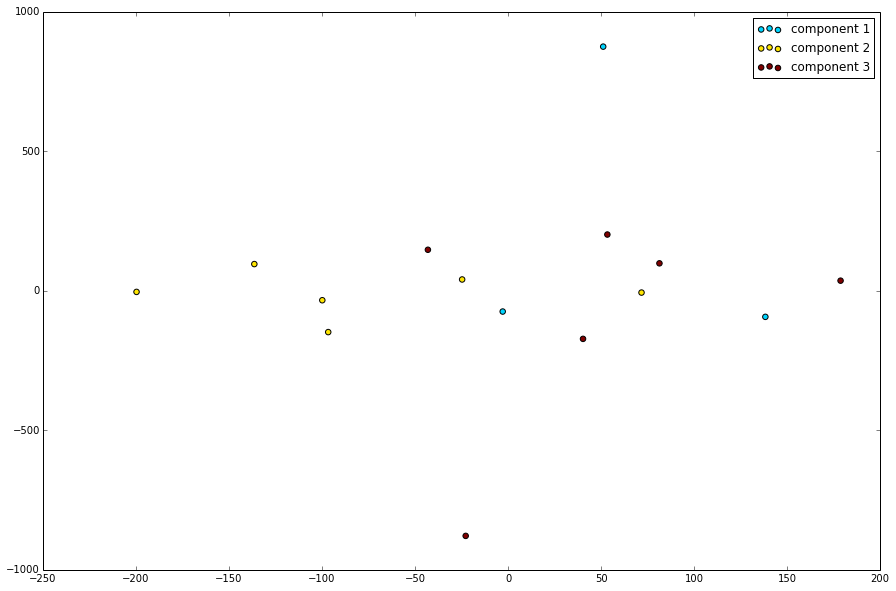


clustering with DBSCAN
count elements in clusters [15]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


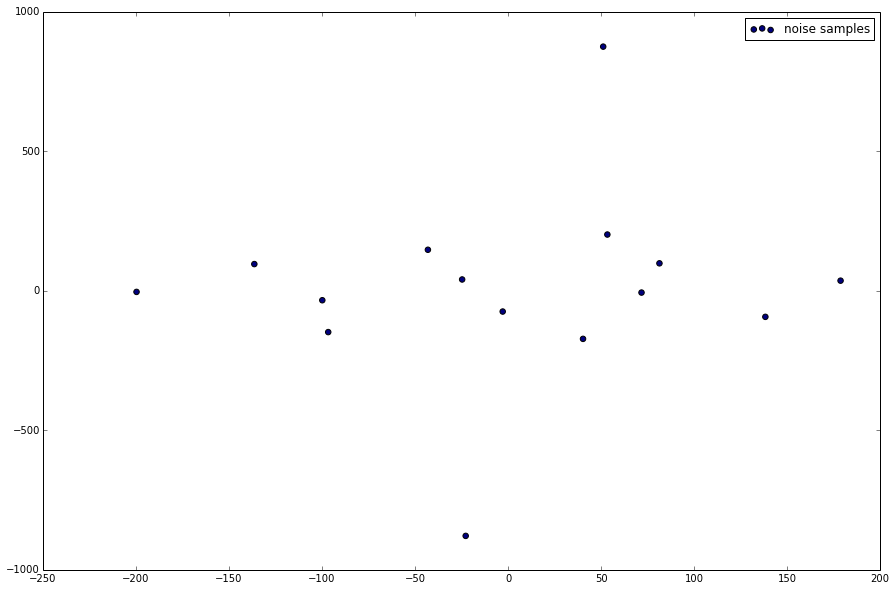


clustering with affinity propagation
count elements in clusters [0 6 9]


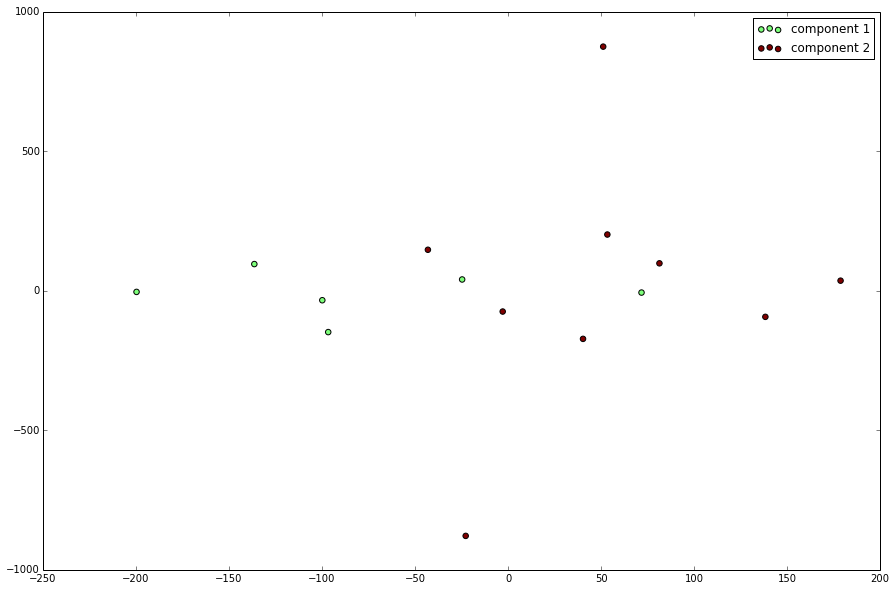


detection no cluster with kmeans_gap_statistics
10
logWkb: 4.684771   logWk: 5.044829  gap: -0.360058 sks: 0.144088 delta: -0.504146
logWkb: 4.178444   logWk: 4.313779  gap: -0.135335 sks: 0.154068 delta: -0.289404
logWkb: 3.869179   logWk: 3.823775  gap: 0.045404 sks: 0.172434 delta: -0.127030
logWkb: 3.633974   logWk: 3.387934  gap: 0.246040 sks: 0.184107 delta: 0.061933
logWkb: 3.417587   logWk: 2.990870  gap: 0.426717 sks: 0.186784 delta: 0.239933
logWkb: 3.223338   logWk: 2.781531  gap: 0.441807 sks: 0.218780 delta: 0.223027
logWkb: 2.994768   logWk: 2.545399  gap: 0.449369 sks: 0.241963 delta: 0.207406
logWkb: 2.752525   logWk: 2.254366  gap: 0.498159 sks: 0.273905 delta: 0.224254
logWkb: 2.468963   logWk: 1.915355  gap: 0.553608 sks: 0.279985 delta: 0.273624
logWkb: 2.155577   logWk: 1.530580  gap: 0.624996 sks: 0.277490 delta: 0.347506
got 4 clusters

detection no cluster with kmeans_silhouette
2 clusters score 0.434590
3 clusters score 0.433899
4 clusters score 0.473317
5 clu

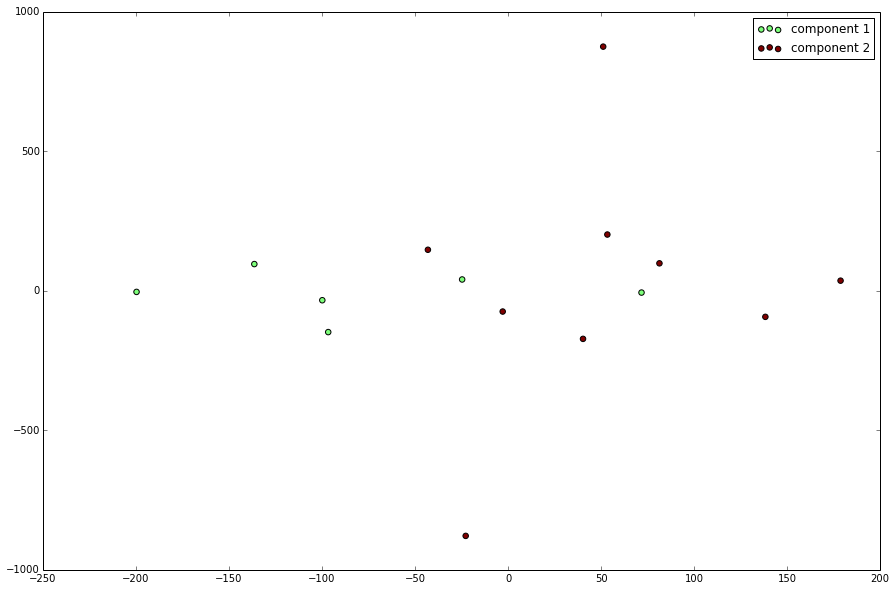

In [58]:
# db.session.rollback()
describe_song_group("forest", 43)
# describe_song_group_type('FALL ASLEEP', 1)
#for gr in db.session.query(Group).order_by(Group.GroupId):
#    describe_song_group(gr.Name, gr.GroupId)

In [17]:
artists_genres = load_artist_genres()
gr_song_features, gr_song_names = load_songs(select_song_group_type(1), count_song_group_type(1))
gr_song_features = gr_song_features[gr_song_features[:,14]>0]
gr_song_features, gr_song_genres, _, _, _ = prepare_songs(gr_song_features, features_scaler)
features = gr_song_features[:,featured_features]
printable_features = gr_song_features[:,:9]

will load 2704 songs


(1978, 1384)

detection no cluster with kmeans_silhouette
2 clusters score 0.274884
3 clusters score 0.167856
4 clusters score 0.157219
5 clusters score 0.163986
6 clusters score 0.153340
7 clusters score 0.149869
8 clusters score 0.152766
9 clusters score 0.105242
10 clusters score 0.117916
got 2 clusters

detection no cluster with kmeans_f_of_K
clusters 2 f_of_K 0.718824
clusters 3 f_of_K 0.917364
clusters 4 f_of_K 0.924675
clusters 5 f_of_K 0.941113
clusters 6 f_of_K 0.959037
clusters 7 f_of_K 0.969823
clusters 8 f_of_K 0.975301
clusters 9 f_of_K 0.973880
clusters 10 f_of_K 0.978361
got 2 clusters -> used for plotting
count elements in clusters [   0 1123  855]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


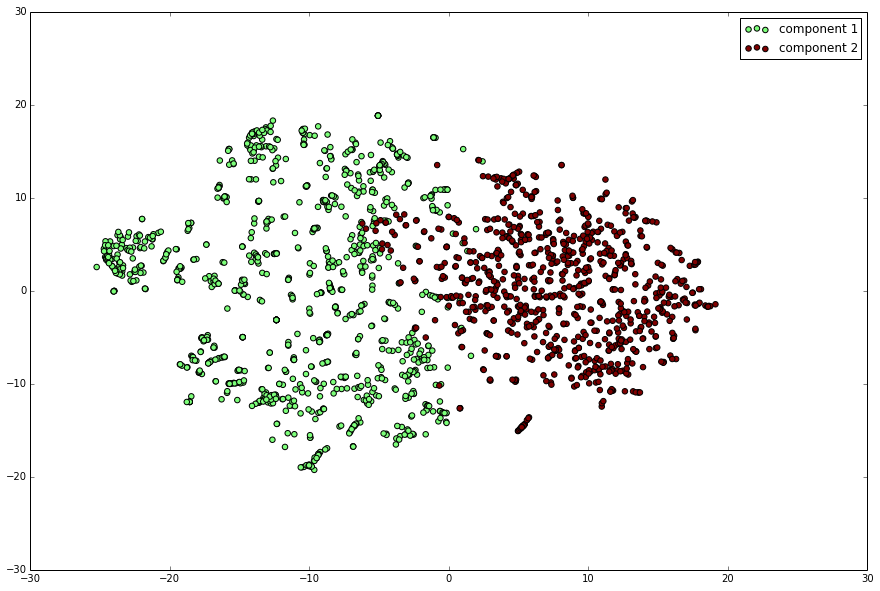

In [30]:
# make one hot encoded features for genres
genres_one_hot = np.zeros([gr_song_features.shape[0], len(genres)])
print(genres_one_hot.shape)
#print(artists_genres)
for row in range(gr_song_features.shape[0]):
    s = gr_song_features[row]
    for g in artists_genres[s[15]]:
        genres_one_hot[row,g-1] = 1
# combine features
combined = np.hstack((features, genres_one_hot))
max_k = 10
#print('')
#print('detection no cluster with kmeans_gap_statistics')
#nc = kmeans_gap_statistics(combined, max_k)
#print('got %i clusters' % nc)
print('')
print('detection no cluster with kmeans_silhouette')
nc = kmeans_silhouette(combined, max_k)
print('got %i clusters' % nc)
print('')
print('detection no cluster with kmeans_f_of_K')
nc = kmeans_f_of_K(combined, max_k)
print('got %i clusters -> used for plotting' % nc)
fit_kmeans(combined, nc)

In [72]:
from api import user_helper
from spotify import spotify_helper


spotify_helper.refresh_token_on_expired = True


def song2track(song_id):
    s = sqlselect([SongTracks.SpotifyId]).where(SongTracks.SongId == song_id)
    return db.session.execute(s).fetchone()[0]


def save_playlist(spotify_user_id, playlist_name, song_ids):
    user = user_helper.load_user(spotify_user_id)
    sp_user_pl = spotify_helper.get_or_create_playlist_by_name(user, playlist_name)
    tracks = [song2track(song_id) for song_id in song_ids]
    print(tracks)
    spotify_helper.set_playlist_content(user, sp_user_pl['id'], tracks)


def outliers_to_playlists(name, features, core_features, gr_song_features, gr_song_names, genres):
    # novelty detection
    clf = sklearn.svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
    clf.fit(core_features)
    y_pred_train = clf.predict(features)
    print('%% of outliers in dataset: %f%%' % (y_pred_train[y_pred_train == -1].size * 100.0 / features.shape[0]))
    y_decision_train = clf.decision_function(features)[:,0]
    y_decision_train_sort = np.argsort(y_decision_train)
    outliers = []
    for sort_id in y_decision_train_sort[:20]:
        if y_pred_train[sort_id] == -1:
            song = gr_song_features[sort_id]
            outliers.append(song[13])
            print('song %s-%s(%i) is outlier with dist %f' % (gr_song_names[song[13]], genres[song[14]],
                                                              song[13], y_decision_train[sort_id]))
    #save_playlist('rudolfix-us', name + ' outliers', outliers)

    print('')
    ingroup = []
    y_decision_train_sort = y_decision_train_sort[::-1]
    for sort_id in y_decision_train_sort[:20]:
        if y_pred_train[sort_id] == 1:
            song = gr_song_features[sort_id]
            ingroup.append(song[13])
            print('song %s-%s(%i) is ingroup with dist %f' % (gr_song_names[song[13]], genres[song[14]],
                                                              song[13], y_decision_train[sort_id]))            
    
    save_playlist('rudolfix-us', name + ' ingroup', ingroup)

In [74]:
def describe_clusters(name, gr_song_features, y_pred, gr_song_names, gr_song_genres):
    y_pred = y_pred + 1
    print('%s %s' % (name, np.bincount(y_pred)))
    print('--------------------------')
    for i, c in enumerate(np.bincount(y_pred)):
        if c>0:
            print('Cluster %i' % i)
            print('---------------------')
            describe_songs(gr_song_features[y_pred==i], gr_song_names, gr_song_genres[y_pred==i])
            
def clusters_to_playlists(name, gr_song_features, y_pred, gr_song_names, gr_song_genres):
    y_pred = y_pred + 1
    print('%s %s' % (name, np.bincount(y_pred)))
    print('--------------------------')
    for i, c in enumerate(np.bincount(y_pred)):
        if c>0:
            print('Cluster %i' % i)
            print('---------------------')
            features = gr_song_features[y_pred==i][:,featured_features]
            gr_top_g_indexer = get_core_genres(gr_song_genres[y_pred==i])
            core_features = features[gr_top_g_indexer]
            outliers_to_playlists('%s cluster %i - ' % (name, i), features, core_features, gr_song_features[y_pred==i],\
                                    gr_song_names, genres)

        
# y_pred = fit_kmeans(genres_one_hot, 3)
# print(gr_song_features.shape)
# print(y_pred.shape)
# print(gr_song_genres.shape)
#y_pred = fit_kmeans(combined, 3)
#describe_clusters('combined', gr_song_features, y_pred, gr_song_names, gr_song_genres)
# y_pred = fit_kmeans(features, 3)
clusters_to_playlists('acoustic features', gr_song_features, y_pred, gr_song_names, gr_song_genres)
#y_pred = fit_kmeans(genres_one_hot, 3)
#describe_clusters('genres_one_hot', gr_song_features, y_pred, gr_song_names, gr_song_genres)

acoustic features [  0 817 704 457]
--------------------------
Cluster 1
---------------------
Genre dance pop count 66
Genre indie folk count 56
Genre folk-pop count 50
Genre pop count 36
Genre neo mellow count 31
Genre acoustic pop count 27
Genre country christmas count 25
Genre viral pop count 23
Genre folk christmas count 19
Genre dreamo count 17
Genre chamber pop count 16
Genre candy pop count 16
Genre australian alternative rock count 13
Genre healing count 12
Genre britpop count 12
Genre shimmer pop count 11
Genre teen pop count 11
Genre boy band count 10
Genre christmas count 10
Genre album rock count 10
Genre metropopolis count 10
% of outliers in dataset: 13.831089%
song So Sick-r&b(30372) is outlier with dist -11.649944
song Sleep Deeper-environmental(834740) is outlier with dist -7.790863
song Hus/hotell/slott brenner-norwegian hip hop(417354) is outlier with dist -7.602208
song Darkness-environmental(834729) is outlier with dist -7.493932
song Apocalypse Dreams-neo-psyched

count elements in clusters [   0  177 1424  377]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


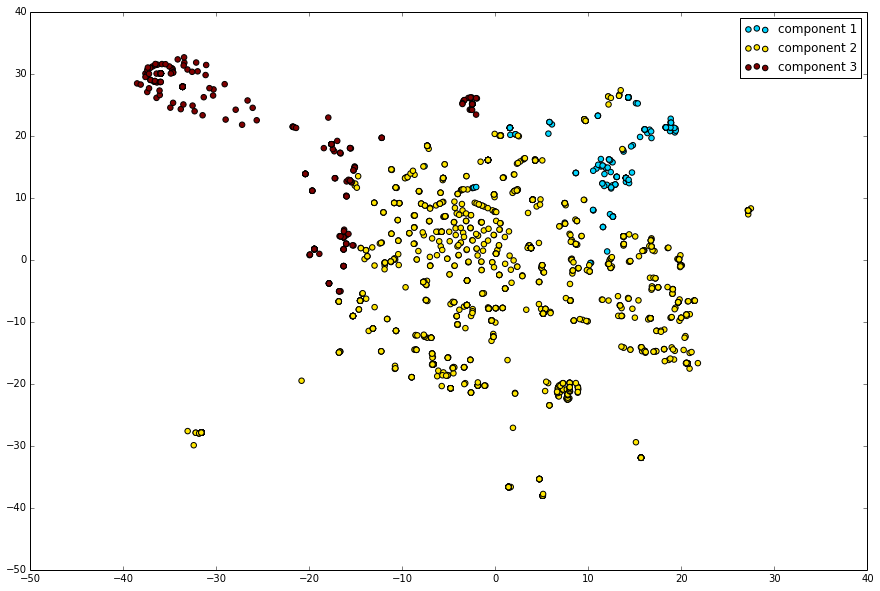

count elements in clusters [  0 457 706 815]


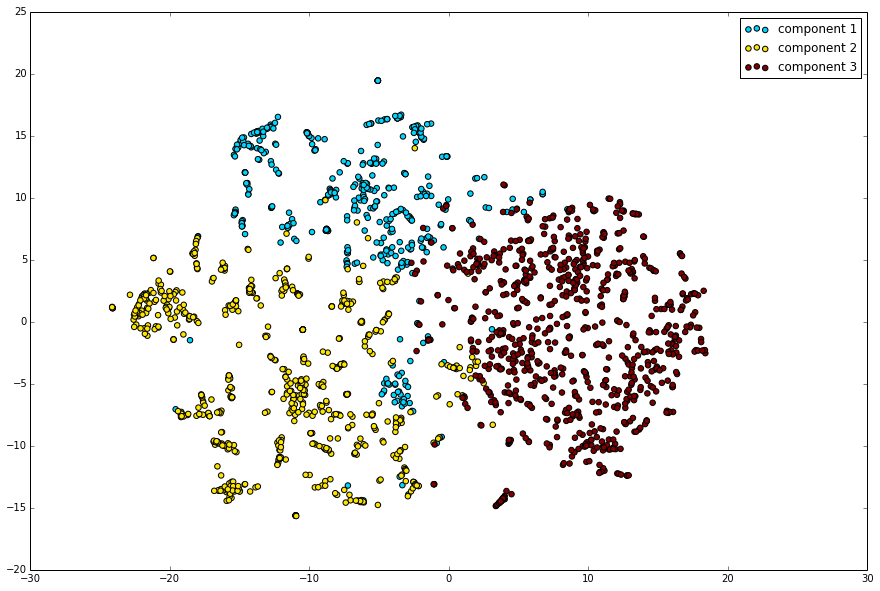

count elements in clusters [  0 815 705 458]


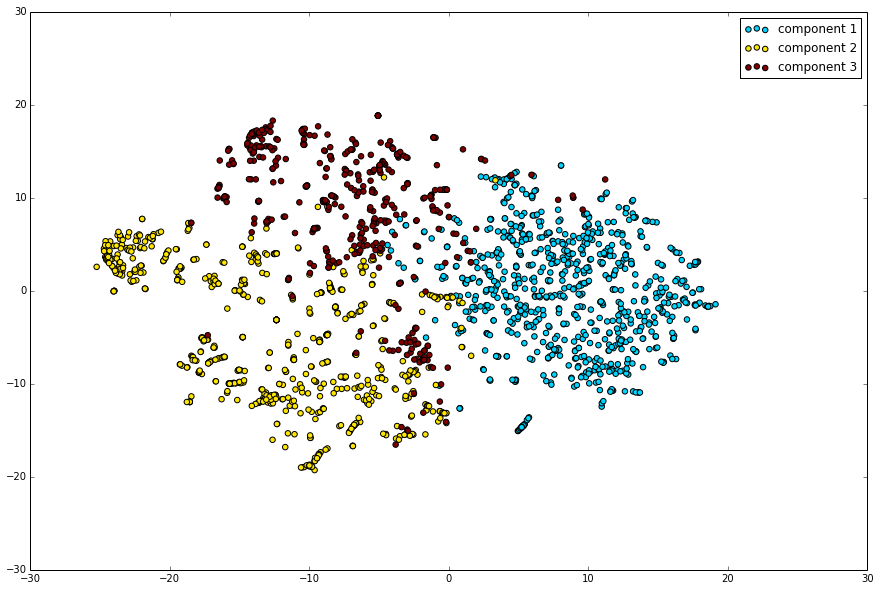

count elements in clusters [  0 460 816 702]


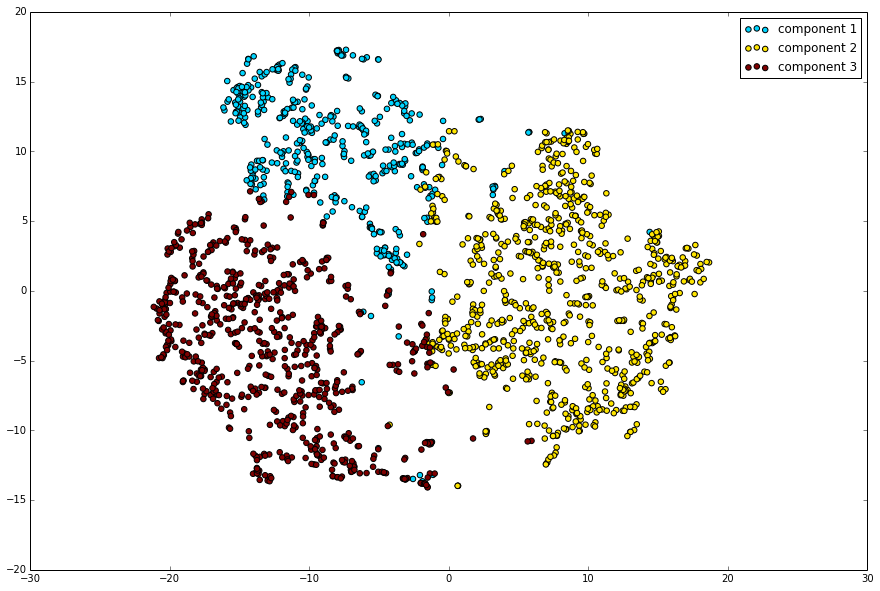

In [41]:
pca = sklearn.decomposition.PCA(n_components=50) # 
pca_proj = pca.fit(combined).transform(combined)

fit_kmeans(genres_one_hot, 3)
fit_kmeans(pca_proj, 3)
fit_kmeans(combined, 3)
fit_kmeans(features, 3)

In [ ]:
featured_features = [0,1,2,3,4,5,7,8]
features = gr_song_features[:,featured_features]

n_clusters_ = 6
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(features, n_neighbors=10, include_self=False)

cls = sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters_, connectivity=connectivity, linkage='ward')
cls.fit(features)
y_pred = cls.labels_
# [{'node_id': next(itertools.count(X.shape[0])), 'left': x[0], 'right':x[1]} for x in clustering.children_]
print('No of clusters %i' % n_clusters_)
# print(y_pred)
y_pred = y_pred + 1
print(np.bincount(y_pred))
components = {0: 'noise samples'}
for c in range(1, n_clusters_+1):
    components[c] = 'component %i' % c
projection = tsne_projection(features) #
plot3(projection, components, color=y_pred)

In [ ]:


# projection = tsne_projection(song_features[1:1000,0:8]) #
# plot2(projection, song_names[1:1000], annotate=False, color=song_genres[1:1000]/1383.0)

#projection = tsne_projection(song_features[song_genres < 10][:,0:8]) #
#projection = tsne_projection(song_features[song_genres < 10][:,[0,1,2,3,4,5,7,8]]) #
plot3(projection, genres, color=song_genres[song_genres < 10])

#isomap = manifold.Isomap(n_neighbors=5,n_components=2)
#X = song_features[song_genres < 10][:,[0,1,3,4,5,7,8]]
#isomap_proj = isomap.fit(X).transform(X)
#plot3(isomap_proj, genres, song_genres[song_genres < 10])

#mds = manifold.MDS(n_components=2, max_iter=100, n_init=1)
#X = song_features[song_genres < 10][:,[0,1,3,4,5,7,8]]
#mds_proj = isomap.fit(X).transform(X)
#plot3(mds_proj, genres, song_genres[song_genres < 10])

#se = manifold.SpectralEmbedding(n_components=2, n_neighbors=10)
#X = song_features[song_genres < 10][:,[0,1,3,4,5,7,8]]
#se_proj = se.fit_transform(X) #fit(X).transform(X)
#plot3(se_proj, genres, song_genres[song_genres < 10])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 
X = song_features[song_genres < 10][:,[0,1,2,3,4,5,7,8]]
pca_proj = pca.fit(X).transform(X)
plot3(pca_proj, genres, song_genres[song_genres < 10])

In [ ]:
# stats for genres
genre_features = np.zeros((len(genres)+1, 9), dtype=np.float32)
for genre_id in genres:
    genre_songs = song_features[song_genres==genre_id,0:9]
    if genre_songs.shape[0] > 0:
        mean = np.mean(genre_songs, axis=0)
        genre_features[genre_id] = mean



In [ ]:
#print(genre_features[np.isnan(genre_features)])
#projection = tsne_projection(genre_features)
#plot(projection, genres, annotate=True, plot_size=50)
#print(np.max(song_features, axis=0))
feature_minimum = np.min(song_features, axis=0)
feature_maximum = np.max(song_features, axis=0)
def print_features(f_vec):
    for i in range(len(f_vec)):
        print('%s: %i%% (%f)'%(feature_names[i], (f_vec[i] - feature_minimum[i])*100/(feature_maximum[i] - 
                                                                                    feature_minimum[i]), f_vec[i]))
#genre_features[346-1]
#print_features(genre_features[346-1])
#print_features(genre_features[1325-1])

#print_features(genre_features[79])

max_genres = np.argmax(genre_features[:,:], axis=0)
for i,g in enumerate(max_genres):
    print('%s - max %s:' % (genres[g], feature_names[i]))
    print_features(genre_features[g])
    print('')
    
    
max_genres = np.argmin(genre_features[:,:], axis=0)
for i,g in enumerate(max_genres):
    print('%s - min %s:' % (genres[g], feature_names[i]))
    print_features(genre_features[g])
    print('')
    
#print(genres[79])


In [ ]:
# mean and deviation are normalized so we can add feature factors directly
def sleepines(features):
    #low energy(0), tempo(2), valence(7), danceability(8), loudness(6)
    #high acousticness(4)
    return feature_maximum[0] - features[0] + feature_maximum[2] - features[2] + feature_maximum[7] - features[7] + \
            feature_maximum[8] - features[8] + feature_maximum[6] - features[6] #+ features[4]

genre_sleepiness = np.zeros(len(genres)+1, dtype=np.float32)
for g_id, features in enumerate(genre_features):
    genre_sleepiness[g_id] = sleepines(features)

genre_sleepiness_sorted_idx = np.argsort(genre_sleepiness)
genre_sleepiness_sorted_idx_rev = genre_sleepiness_sorted_idx[::-1]


In [ ]:
for g_id in genre_sleepiness_sorted_idx_rev:
    if g_id in genres:
        print('genre %i - %s sleepiness %f' % (g_id, genres[g_id], genre_sleepiness[g_id]))
        
print_features(genre_features[10])

In [ ]:
G = nx.DiGraph()

for i, g_id in enumerate(genre_sleepiness_sorted_idx_rev):  # work on reverse
    if g_id in genres:
        max_nb = min(i+5, len(genre_sleepiness_sorted_idx))  # 5 neighbours
        for nb in range(i+1, max_nb):
            n_g_id = genre_sleepiness_sorted_idx_rev[nb]
            if n_g_id in genres: #genre_sleepiness[n_g_id] - genre_sleepiness[g_id]
                G.add_edge(genres[g_id], genres[n_g_id], weight=genre_sleepiness[g_id] - genre_sleepiness[n_g_id])

In [ ]:
pylab.figure(1, figsize=(8, 8))
# layout graphs with positions using graphviz neato
pos = graphviz_layout(G, prog="neato")
nx.draw(G, pos,
             node_size=40,
             vmin=0.0,
             vmax=1.0,
             with_labels=False)

In [ ]:
# print(G['disco house'])
# print(G['deep alternative r&b'])

#paths = list(nx.shortest_simple_paths(G, 'deep alternative r&b', 'disco house'))
#print(paths)
from itertools import islice

def k_shortest_paths(G, source, target, k, weight=None):
    return list(islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

for path in k_shortest_paths(G, 'deep alternative r&b', 'disco house', 1, weight='weight'):
    print(path)

In [ ]:
#np.max(song_genres)
#np.bincount(song_genres[1:1000])
# song_genres[1:1000]/1383.0
#song_names[1:1000].shape
#projection[:,2]
#flabels = song_names[song_genres < 10]
#len(flabels)
#print(len(genres))
#print(np.mean(song_features, axis=0))
#print(np.std(song_features, axis=0))
#print(np.max(song_features, axis=0))
#print(np.min(song_features, axis=0))
#projection
#genres
#for i, label in enumerate(genres):
#    print('%i - %s' % (i,label))
#print(np.mean(genre_features, axis=0))
#print(np.std(genre_features, axis=0))
#print(np.max(genre_features, axis=0))
#print(np.min(genre_features, axis=0))
# print(song_names[9943])
# print(song_features[song_features[:, 13] == 9943])
# print(song_features[song_features[:, 14] == 10, 0])
print(np.mean(song_features[song_features[:, 14] == 10, 0]))
print(genre_features[9])